In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet optuna

In [5]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import xgboost
import optuna

import warnings
warnings.filterwarnings("ignore")

In [7]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

In [8]:
display(train.head())

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [9]:
test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


## Предобработка

### train

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [11]:
train.duplicated().sum()

0

Явные дубликаты отсутствуют

In [12]:
train.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

#### year

In [ ]:
train['year'].unique()

array([2011, 2014, 2012, 2003, 2007, 2013, 2010, 2000, 2005, 2006, 2004,
       2008, 2009, 2015, 2002, 2001, 1999, 1998, 1996, 1997, 1994, 1995,
       1993, 1989, 1991, 1988, 1987, 1990, 1992, 1985, 1986, 1983, 1984,
       1982])

#### make

In [ ]:
train['make'].sort_values().unique()

array(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT',
       'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda',
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'MINI',
       'Maserati', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi',
       'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram',
       'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki',
       'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'airstream',
       'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler',
       'dodge', 'dodge tk', 'dot', 'ford', 'ford truck', 'gmc',
       'gmc truck', 'honda', 'hyundai', 'jeep', 'kia', 'land rover',
       'landrover', 'lexus', 'lincoln', 'maserati', 'mazda', 'mazda tk',
       'mercedes', 'mercedes-b', 'mercury', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac

In [ ]:
train['make'].isna().sum()

8043

In [ ]:
train = train.dropna(subset=['make'])

In [ ]:
train['make'].isna().sum()

0

In [ ]:
train['make'] = train['make'].str.lower()
train['make'] = train['make'].str.replace('vw', 'volkswagen')
train['make'] = train['make'].str.replace('landrover', 'land rover')
train['make'] = train['make'].str.replace('mazda tk', 'mazda')
train['make'] = train['make'].str.replace('mercedes-b', 'mercedes')
train['make'] = train['make'].str.replace('mercedes-benz', 'mercedes')
train['make'] = train['make'].str.replace('dodge tk', 'dodge')
train['make'] = train['make'].str.replace('ford truck', 'ford')
train['make'] = train['make'].str.replace('gmc truck', 'gmc')
train['make'] = train['make'].str.replace('mercedesenz', 'mercedes')


In [ ]:
train['make'].sort_values().unique()

array(['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge',
       'dot', 'ferrari', 'fiat', 'fisker', 'ford', 'geo', 'gmc', 'honda',
       'hummer', 'hyundai', 'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia',
       'lamborghini', 'land rover', 'lexus', 'lincoln', 'maserati',
       'mazda', 'mercedes', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo'], dtype=object)

Удалены пропуски. Названия производителей приведены к нижнему регистру. Переименованы повторяющиеся названия.

#### model

In [ ]:
train['model'].sort_values().unique()

array(['1 Series', '1500', '190-Class', '2 Series', '200', '200SX',
       '2500', '3', '3 Series', '3 Series Gran Turismo', '300',
       '300-Class', '3000GT', '300M', '300ZX', '300e', '320i', '323i',
       '328i', '3500', '350Z', '350z', '370Z', '4 Series',
       '4 Series Gran Coupe', '400-Class', '420-Class', '420sel', '42c',
       '458 Italia', '4Runner', '5 Series', '5 Series Gran Turismo',
       '500', '500-Class', '500L', '500e', '6', '6 Series',
       '6 Series Gran Coupe', '626', '7', '7 Series', '750i', '750li',
       '750lxi', '8 Series', '850', '9-2X', '9-3', '9-5', '9-7X', '911',
       '940', '960', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'ATS', 'Acadia',
       'Accent', 'Accord', 'Accord Crosstour', 'Accord Hybrid',
       'ActiveHybrid 5', 'ActiveHybrid 7', 'ActiveHybrid X6', 'Aerio',
       'Alero', 'Altima', 'Altima Hybrid', 'Amanti', 'Amigo', 'Armada',
       'Ascender', 'Aspen', 'Aspire', 'Astra', 'Astro', 'Astro Cargo',
       'Aura', 'Aura Hybrid', 'Aurora', 

In [ ]:
train['model'].isna().sum()

80

In [ ]:
train = train.dropna(subset=['model'])

In [ ]:
train['model'].isna().sum()

0

In [ ]:
train['model'] = train['model'].str.lower()

In [ ]:
model_count = train.groupby('model')['model'].count().sort_values(ascending=False)

<Axes: >

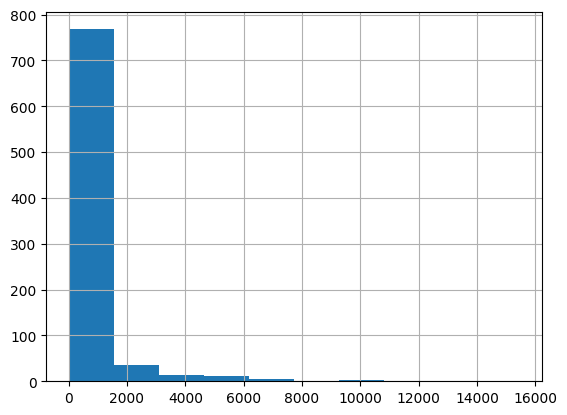

In [ ]:
model_count.hist()

In [ ]:
common_models = model_count[model_count > 2000].index

In [ ]:
train['model'] = train['model'].apply(lambda x: 'rare' if x not in common_models else x)

Удалены пропуски. Названия моделей приведены к нижнему регистру. Редко встечающиеся (<2000) модели переименованы в 'rare'


#### trim

In [ ]:
train['trim'].sort_values().nunique()

1921

In [ ]:
train = train.dropna(subset=['trim'])

In [ ]:
train['trim'] = train['trim'].str.lower()

In [ ]:
trim_count = train.groupby('trim')['trim'].count().sort_values(ascending=False)

<Axes: >

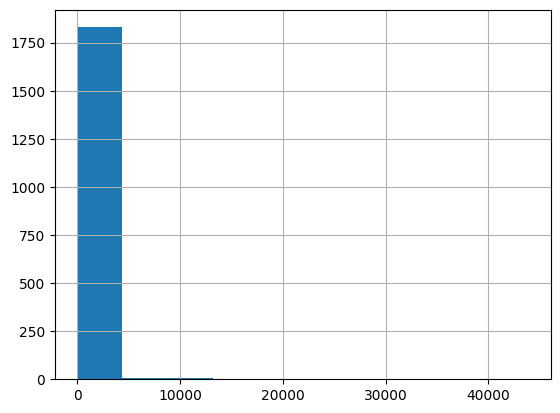

In [ ]:
trim_count.hist()

In [ ]:
common_trim = trim_count[trim_count > 2000].index

In [ ]:
train['trim'] = train['trim'].apply(lambda x: 'rare' if x not in common_trim else x)

Удалены пропуски. Названия модификаций приведены к нижнему регистру. Редко встечающиеся (<2000) модификации переименованы в 'rare'.

#### body

In [ ]:
train['body'].sort_values().unique()

array(['Access Cab', 'Beetle Convertible', 'CTS Coupe', 'CTS Wagon',
       'CTS-V Coupe', 'CTS-V Wagon', 'Cab Plus', 'Cab Plus 4', 'Club Cab',
       'Convertible', 'Coupe', 'Crew Cab', 'CrewMax Cab', 'Double Cab',
       'E-Series Van', 'Elantra Coupe', 'Extended Cab', 'G Convertible',
       'G Coupe', 'G Sedan', 'G37 Convertible', 'G37 Coupe',
       'Genesis Coupe', 'GranTurismo Convertible', 'Hatchback',
       'King Cab', 'Koup', 'Mega Cab', 'Minivan', 'Promaster Cargo Van',
       'Q60 Convertible', 'Q60 Coupe', 'Quad Cab', 'Ram Van',
       'Regular Cab', 'SUV', 'Sedan', 'SuperCab', 'SuperCrew',
       'TSX Sport Wagon', 'Transit Van', 'Van', 'Wagon', 'Xtracab',
       'access cab', 'beetle convertible', 'cab plus 4', 'club cab',
       'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe',
       'cts-v coupe', 'double cab', 'e-series van', 'elantra coupe',
       'extended cab', 'g convertible', 'g coupe', 'g sedan',
       'g37 convertible', 'g37 coupe', 'genesis c

In [ ]:
train['body'] = train['body'].str.lower()
train['body'] = train['body'].str.replace('regular-cab', 'regular cab')
train = train.dropna(subset=['body'])

In [ ]:
train['body'].sort_values().unique()

array(['access cab', 'beetle convertible', 'cab plus', 'cab plus 4',
       'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab',
       'cts coupe', 'cts wagon', 'cts-v coupe', 'cts-v wagon',
       'double cab', 'e-series van', 'elantra coupe', 'extended cab',
       'g convertible', 'g coupe', 'g sedan', 'g37 convertible',
       'g37 coupe', 'genesis coupe', 'granturismo convertible',
       'hatchback', 'king cab', 'koup', 'mega cab', 'minivan',
       'promaster cargo van', 'q60 convertible', 'q60 coupe', 'quad cab',
       'ram van', 'regular cab', 'sedan', 'supercab', 'supercrew', 'suv',
       'transit van', 'tsx sport wagon', 'van', 'wagon', 'xtracab'],
      dtype=object)

Удалены пропуски. Названия типов кузовов приведены к нижнему регистру. Переименованы повторяющиеся названия.

#### transmission

In [ ]:
train['transmission'].sort_values().unique()

array(['automatic', 'manual', nan], dtype=object)

In [ ]:
train.groupby('transmission')['vin'].count()

transmission
automatic    366866
manual        13161
Name: vin, dtype: int64

In [ ]:
train['transmission'] = train['transmission'].fillna('automatic')

Пропуски заполнены наиболее частым значением('automatic')

#### state

In [ ]:
train['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

#### condition

In [ ]:
train['condition'].sort_values().unique()

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , nan])

In [ ]:
train['condition'] = train['condition'].fillna(np.round(train['condition'].mean(), 1))

Пропуски заполнены средним значением.

#### odometer

In [ ]:
train['odometer'] = train['odometer'].fillna(train['odometer'].mean())

Пропуски заполнены средним значением.

#### color

In [ ]:
train['color'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

In [ ]:
train['color'] = train['color'].fillna('—')

Пропуски заполнены значением '—'

#### interior

In [ ]:
train['interior'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

In [ ]:
train['colinterioror'] = train['interior'].fillna('—')

Пропуски заполнены значением '—'

#### seller

In [ ]:
train['seller'].nunique()

12786

In [ ]:
seller_count = train.groupby('seller')['seller'].count().sort_values(ascending=False)

<Axes: >

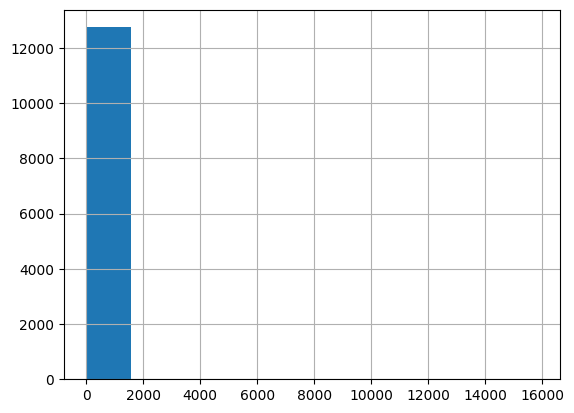

In [ ]:
seller_count.hist()

In [ ]:
common_seller = seller_count[seller_count > 2000].index

In [ ]:
train['seller'] = train['seller'].apply(lambda x: 'rare' if x not in common_seller else x)

Редко встечающиеся (<2000) названия продавцов переименованы в 'rare'.

### test

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


In [ ]:
test.isna().sum()

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13012
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

#### year

In [ ]:
test['year'].sort_values().unique()

array([1982, 1984, 1986, 1987, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

#### make

In [ ]:
test['make'].sort_values().unique()

array(['Acura', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge', 'FIAT',
       'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo', 'HUMMER', 'Honda',
       'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'MINI', 'Maserati',
       'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan',
       'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Ram',
       'Rolls-Royce', 'Saab', 'Saturn', 'Scion', 'Subaru', 'Suzuki',
       'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'acura', 'audi', 'bmw',
       'buick', 'cadillac', 'chev truck', 'chevrolet', 'chrysler',
       'dodge', 'ford', 'ford tk', 'gmc', 'honda', 'hyundai',
       'hyundai tk', 'jeep', 'kia', 'land rover', 'landrover', 'lexus',
       'lincoln', 'mazda', 'mercedes', 'mercury', 'mitsubishi', 'nissan',
       'oldsmobile', 'pontiac', 'porsche', 'smart', 'subaru', 'toyota',
       'volkswagen', 'vw', nan], dtype=o

In [ ]:
test['make'] = test['make'].str.lower()
test['make'] = test['make'].str.replace('chev truck', 'chevrolet')
test['make'] = test['make'].str.replace('ford tk', 'ford')
test['make'] = test['make'].str.replace('hyundai tk', 'hyundai') 
test['make'] = test['make'].str.replace('landrover', 'land rover')
test['make'] = test['make'].str.replace('mercedes-benz', 'mercedes')
test['make'] = test['make'].str.replace('vw', 'volkswagen') 
test['make'] = test['make'].fillna('-')

Пропуски заполнены значением '-'. Названия производителей приведены к нижнему регистру. Переименованы повторяющиеся названия.

#### model

In [ ]:
test['model'].sort_values().unique()

array(['1', '1 Series', '1500', '2 Series', '200', '200SX', '2500', '3',
       '3 Series', '3 Series Gran Turismo', '300', '300-Class', '3000GT',
       '300M', '300ZX', '300e', '350', '3500', '350Z', '350z', '360',
       '370Z', '4 Series', '4 Series Gran Coupe', '4Runner', '5 Series',
       '5 Series Gran Turismo', '500', '500L', '6', '6 Series',
       '6 Series Gran Coupe', '626', '7 Series', '750i', '750li', '850',
       '9-2X', '9-3', '9-5', '9-7X', '911', 'A3', 'A4', 'A5', 'A6', 'A7',
       'A8', 'ATS', 'Acadia', 'Accent', 'Accord', 'Accord Crosstour',
       'Accord Hybrid', 'Achieva', 'ActiveHybrid 5', 'ActiveHybrid X6',
       'Aerio', 'Alero', 'Altima', 'Altima Hybrid', 'Amanti', 'Armada',
       'Ascender', 'Aspen', 'Aspire', 'Astra', 'Astro', 'Astro Cargo',
       'Aura', 'Aurora', 'Avalanche', 'Avalon', 'Avalon Hybrid',
       'Avenger', 'Aveo', 'Aviator', 'Axiom', 'Azera', 'Aztek',
       'B-Class Electric Drive', 'B-Series Pickup', 'B-Series Truck',
       'B9 Trib

In [ ]:
test['model'] = test['model'].str.lower()
test['model'] = test['model'].fillna('-')

In [ ]:
test['model'] = test['model'].apply(lambda x: 'rare' if x not in common_models else x)

Пропуски заполнены значением '-'. Названия моделей приведены к нижнему регистру. Редкие значения заменены на 'rare'.

#### trim

In [ ]:
test['trim'].nunique()

1496

In [ ]:
test['trim'] = test['trim'].str.lower()
test['trim'] = test['trim'].fillna('-')

In [ ]:
test['trim'] = test['trim'].apply(lambda x: 'rare' if x not in common_trim else x)

Пропуски заполнены значением '-'. Названия модификаций приведены к нижнему регистру. Редкие значения заменены на 'rare'.

#### body

In [ ]:
test['body'].sort_values().unique()

array(['Access Cab', 'Beetle Convertible', 'CTS Coupe', 'CTS Wagon',
       'CTS-V Coupe', 'Cab Plus', 'Club Cab', 'Convertible', 'Coupe',
       'Crew Cab', 'CrewMax Cab', 'Double Cab', 'E-Series Van',
       'Elantra Coupe', 'Extended Cab', 'G Convertible', 'G Coupe',
       'G Sedan', 'G37 Convertible', 'G37 Coupe', 'Genesis Coupe',
       'GranTurismo Convertible', 'Hatchback', 'King Cab', 'Koup',
       'Mega Cab', 'Minivan', 'Promaster Cargo Van', 'Q60 Convertible',
       'Q60 Coupe', 'Quad Cab', 'Regular Cab', 'SUV', 'Sedan', 'SuperCab',
       'SuperCrew', 'TSX Sport Wagon', 'Transit Van', 'Van', 'Wagon',
       'Xtracab', 'access cab', 'club cab', 'convertible', 'coupe',
       'crew cab', 'crewmax cab', 'cts coupe', 'cts-v coupe',
       'double cab', 'e-series van', 'elantra coupe', 'extended cab',
       'g convertible', 'g coupe', 'g sedan', 'genesis coupe',
       'granturismo convertible', 'hatchback', 'king cab', 'koup',
       'mega cab', 'minivan', 'promaster cargo v

In [ ]:
test['body'] = test['body'].str.lower()
test['body'] = test['body'].str.replace('regular-cab', 'regular cab')
test['body'] = test['body'].fillna('-')

Пропуски заполнены значением '-'. Названия типов кузова приведены к нижнему регистру. Переименованы повторяющиеся названия.

#### transmission

In [ ]:
test['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

In [ ]:
test['transmission'] = test['transmission'].fillna('automatic')

Пропуски заполнены наиболее частым значением('automatic')

#### state

In [ ]:
test['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

#### condition

In [ ]:
test['condition'].sort_values().unique()

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , nan])

In [ ]:
test['condition'] =  test['condition'].fillna(np.round(test['condition'].mean(), 1))

Пропуски заполнены средним значением.

#### odometer

In [ ]:
test['odometer'].head(5)

0    116970.0
1      6286.0
2     11831.0
3     57105.0
4     31083.0
Name: odometer, dtype: float64

In [ ]:
test['odometer'] = test['odometer'].fillna(np.round(test['odometer'].mean(), 0))

Пропуски заполнены средним значением.

#### color

In [ ]:
test['color'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

In [ ]:
test['color'] = test['color'].fillna('—')

Пропуски заполнены значением '—'

#### interior

In [ ]:
test['interior'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

In [ ]:
test['interior'] = test['interior'].fillna('—')

Пропуски заполнены значением '—'

#### seller

In [ ]:
test['seller'] = test['seller'].apply(lambda x: 'rare' if x not in common_seller else x)

Редко встечающиеся названия продавцов переименованы в 'rare'.

## Исследовательский анализ

### train

In [ ]:
train['saledate'] = pd.to_datetime(train['saledate'], utc=True)

In [ ]:
train['sale_month'] = train['saledate'].dt.month
train['sale_year'] = train['saledate'].dt.year

In [ ]:
train = train.drop('saledate', axis=1)

In [ ]:
train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,colinterioror,sale_month,sale_year
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,black,6,2015
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,black,2,2015
2,2012,nissan,sentra,rare,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,black,6,2015
3,2003,hummer,rare,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,rare,13300,beige,6,2015
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,rare,1300,black,2,2015


In [ ]:
train['age'] = train['sale_year'] - train['year']

In [ ]:
train = train.drop(['sale_year', 'year'], axis=1)

Из 'saledate' были получены месяц и год продажи. Из года производсва авто и года продажи был получен возраст авто, который был записан в 'age'. 

#### transmission

<Axes: >

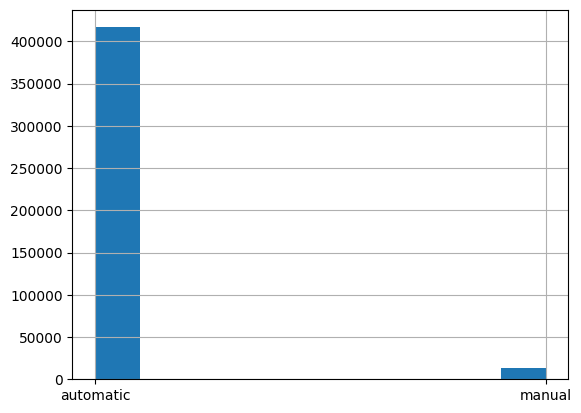

In [ ]:
train['transmission'].hist()

#### state

<Axes: >

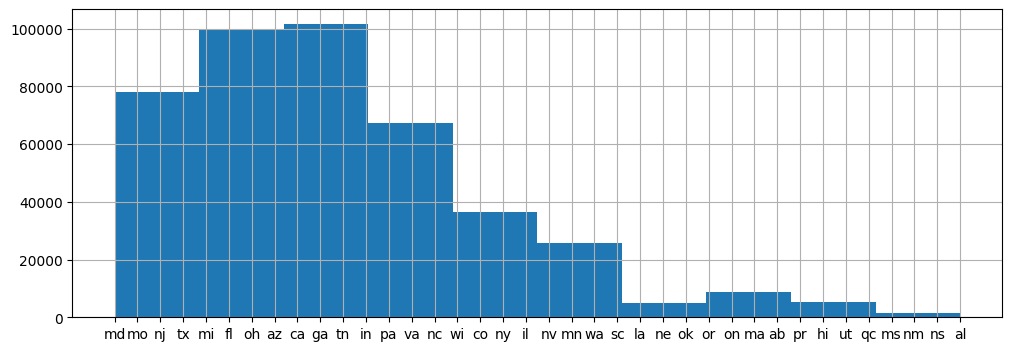

In [ ]:
train['state'].hist(figsize=(12, 4))

#### condition

<Axes: >

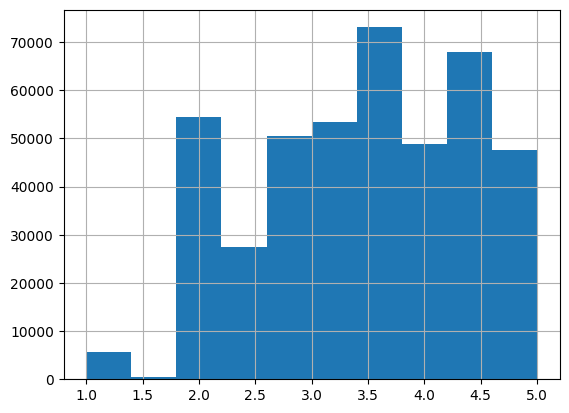

In [ ]:
train['condition'].hist()

#### odometer

<Axes: >

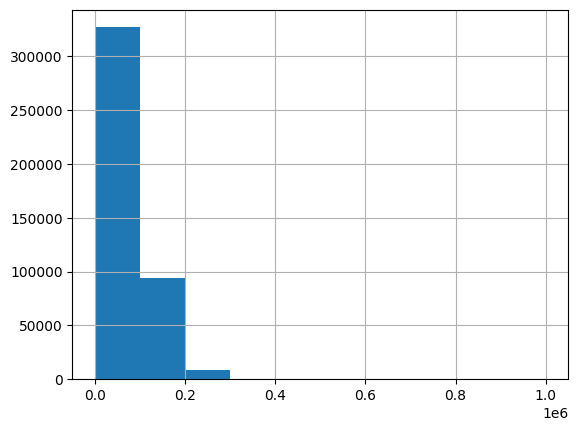

In [ ]:
train['odometer'].hist()

<Axes: >

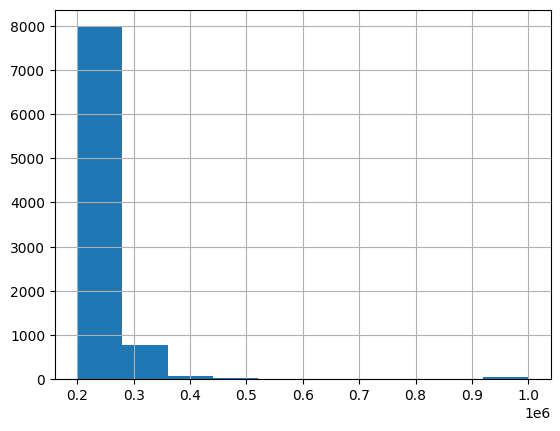

In [ ]:
train['odometer'].hist(range=[200000, 1000000])

In [ ]:
train = train[train['odometer'] < 350000]

Редкие значения пробега были удалены

#### sellingprice

<Axes: >

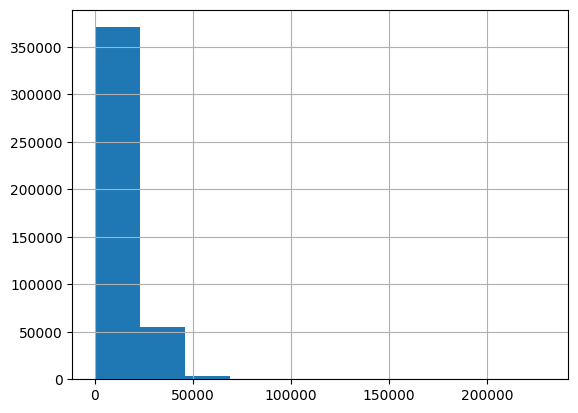

In [ ]:
train['sellingprice'].hist()

In [ ]:
train = train[train['sellingprice'] < 55000]

Редкие значения цены были удалены

#### sale_month

<Axes: >

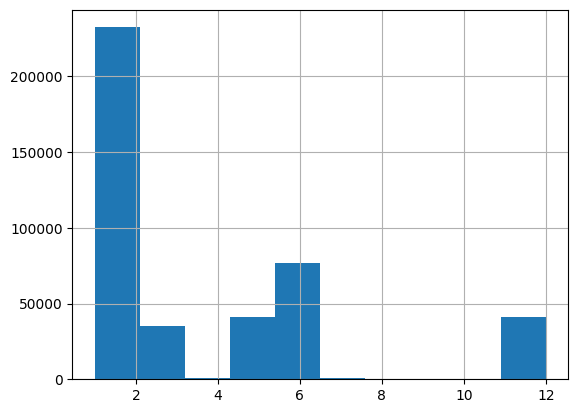

In [ ]:
train['sale_month'].hist()

#### age

<Axes: >

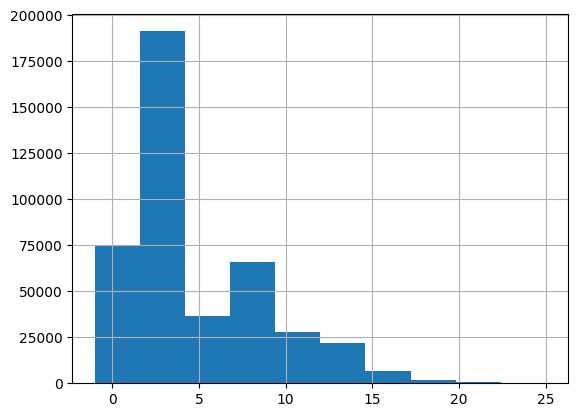

In [ ]:
train['age'].hist()

### test

In [ ]:
test['saledate'] = pd.to_datetime(test['saledate'], utc=True)

In [ ]:
test['sale_month'] = test['saledate'].dt.month
test['sale_year'] = test['saledate'].dt.year

In [ ]:
test = test.drop('saledate', axis=1)

In [ ]:
test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sale_month,sale_year
0,2005,cadillac,rare,base,sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,rare,1,2015
1,2014,gmc,rare,rare,van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,rare,2,2015
2,2013,nissan,murano,s,suv,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2,2015
3,2013,chevrolet,impala,rare,sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,rare,3,2015
4,2013,nissan,rare,sv,crew cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,6,2015


In [ ]:
test['age'] = test['sale_year'] - test['year']
test = test.drop(['year', 'sale_year'], axis=1)

Из 'saledate' были получены месяц и год продажи. Из года производсва авто и года продажи был получен возраст авто, который был записан в 'age'. 

#### transmission

<Axes: >

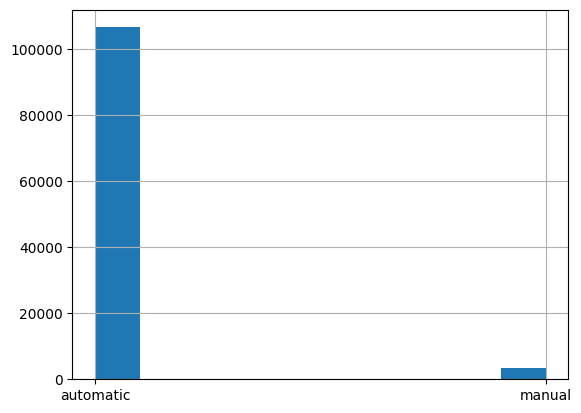

In [ ]:
test['transmission'].hist()

#### state

<Axes: >

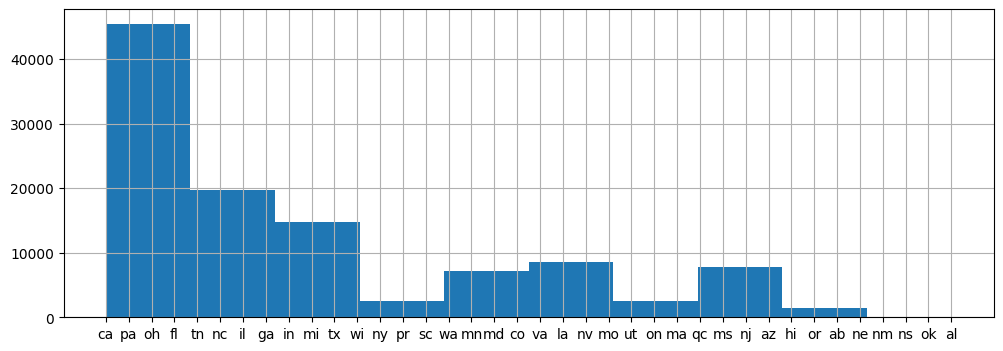

In [ ]:
test['state'].hist(figsize=(12, 4))

#### condition

<Axes: >

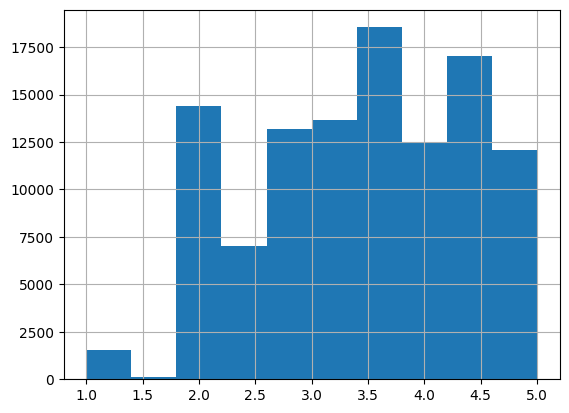

In [ ]:
test['condition'].hist()

#### odometer

<Axes: >

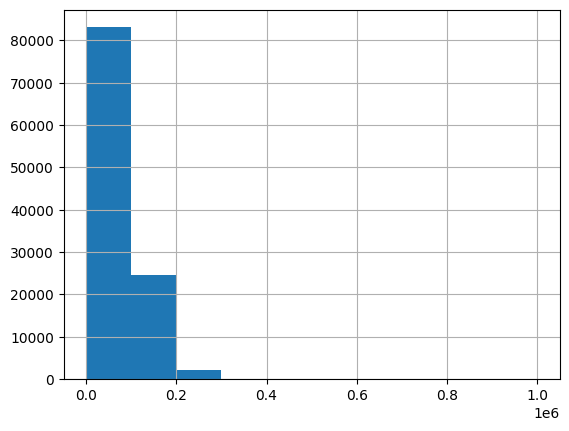

In [ ]:
test['odometer'].hist()

#### sale_month

<Axes: >

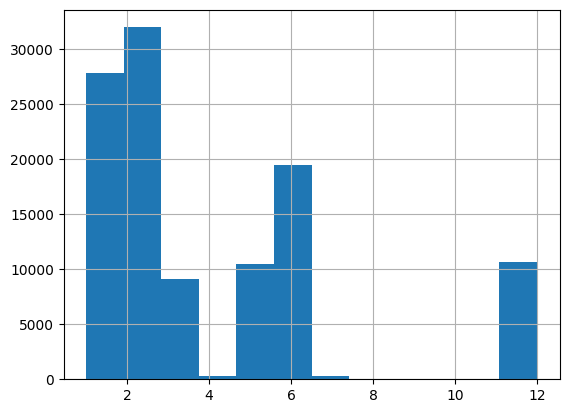

In [ ]:
test['sale_month'].hist(bins=12)

#### age

<Axes: >

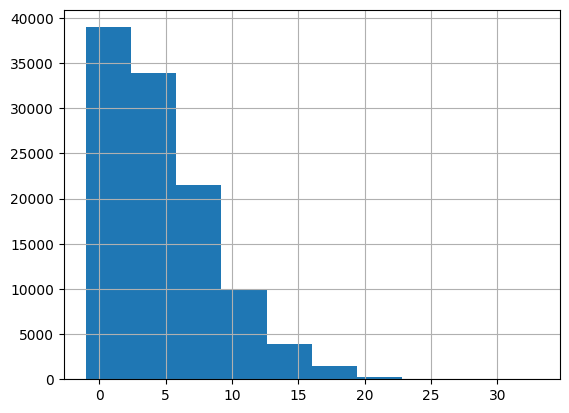

In [ ]:
test['age'].hist()

## Мультиколлинеарность

### train

In [ ]:
train.corr()

,condition,odometer,sellingprice,sale_month,age
condition,1.000000,-0.532403,0.553383,-0.017697,-0.535822
odometer,-0.532403,1.000000,-0.620238,0.043047,0.790251
sellingprice,0.553383,-0.620238,1.000000,-0.037097,-0.617582
sale_month,-0.017697,0.043047,-0.037097,1.000000,-0.014793
age,-0.535822,0.790251,-0.617582,-0.014793,1.000000


In [ ]:
vif_data = pd.DataFrame()
X = train[['condition', 'odometer', 'age']]
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

     feature       VIF
0  condition  1.891070
1   odometer  6.879775
2        age  6.540631


### test

In [ ]:
test.corr()

,condition,odometer,sale_month,age
condition,1.000000,-0.524281,-0.012373,-0.534832
odometer,-0.524281,1.000000,0.037620,0.765565
sale_month,-0.012373,0.037620,1.000000,-0.016972
age,-0.534832,0.765565,-0.016972,1.000000


In [ ]:
vif_data = pd.DataFrame()
X = test[['condition', 'odometer', 'age']]
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

     feature       VIF
0  condition  1.868952
1   odometer  6.056653
2        age  5.864023


## Обучение моделей

In [ ]:
X = train[['state', 'age', 'make', 'model', 'trim', 'body', 'transmission', 'condition', 'odometer', 'color', 'interior', 'seller', 'sale_month']]
y = train['sellingprice']
test_vin = test['vin']
X_test = test[['state', 'age', 'make', 'model', 'trim', 'body', 'transmission', 'condition', 'odometer', 'color', 'interior', 'seller', 'sale_month']]
X_test = pd.get_dummies(X_test)
X = pd.get_dummies(X)
X = X[X.columns.intersection(X_test.columns)]
X_test = X_test[X_test.columns.intersection(X.columns)]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=0)

In [ ]:
scaler = StandardScaler()
numeric_features = ['condition', 'age', 'odometer']
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    return mean_absolute_percentage_error(y_val, pred)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)
print('Best parameters', study.best_params)
print('Best value', study.best_value)
print('Best trial', study.best_trial)


Best parameters {'max_depth': 9, 'learning_rate': 0.22554172902940153, 'n_estimators': 398, 'min_child_weight': 7, 'gamma': 0.268544813736836, 'subsample': 0.6372635278026426, 'colsample_bytree': 0.697532697424521, 'reg_alpha': 0.7740332421866251, 'reg_lambda': 0.5796227263556395, 'random_state': 1}
Best value 0.21827587258629408
Best trial FrozenTrial(number=59, state=TrialState.COMPLETE, values=[0.21827587258629408], datetime_start=datetime.datetime(2023, 5, 1, 19, 40, 15, 418862), datetime_complete=datetime.datetime(2023, 5, 1, 19, 43, 18, 468146), params={'max_depth': 9, 'learning_rate': 0.22554172902940153, 'n_estimators': 398, 'min_child_weight': 7, 'gamma': 0.268544813736836, 'subsample': 0.6372635278026426, 'colsample_bytree': 0.697532697424521, 'reg_alpha': 0.7740332421866251, 'reg_lambda': 0.5796227263556395, 'random_state': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rat

In [ ]:
model = xgboost.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
pred = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, pred)
test_predictions = model.predict(X_test)
print(mape)

0.21827587258629408


Данные были разбиты на тестовую и валидационную выборки. С помощью pd.get_dummies были обработаны категориальные признаки. Было произведено масштабирование численных признаков.

С помощью optuna были подобраны оптимальные знацения параметров для XGBRegressor. В результате проверки на валидационной выборке было получено значение MAPE 0.21827587258629408

In [ ]:
submission = pd.DataFrame()
submission['vin'] = test_vin
submission['sellingprice'] = test_predictions
submission.head()

,vin,sellingprice
0,1g6dp567450124779,5030.188477
1,1gtw7fca7e1902207,22029.173828
2,jn8az1mw6dw303497,19387.892578
3,2g1wf5e34d1160703,9271.338867
4,1n6aa0ec3dn301209,22285.679688


In [ ]:
submission.shape

(110060, 2)